# Data visualisation

The COVID-19-CT-Seg dataset has the following sub-directory structure:             

    ./COVID-19-CT-Seg
    │
    ├── Data                               # Volumetric CT scans belonging to 20 patients with Covid-19
    │   ├── coronacases_001.nii.gz         # 3D scan for patient 1, encoded as a NIfTI file
    │   ⋮
    ├── Lung_Mask                          # Segmentation masks for left and right lung labels
    │   ├── coronacases_001.nii.gz
    │   ⋮  
    ├── Infection_Mask                     # Segmentation masks for infection label
    │   ├── coronacases_001.nii.gz         
    │   ⋮                
    └── Lung_and_Infection_Mask            # Segmentation masks for both lungs and infection labels (infection masks overlap lungs masks)
        ├── coronacases_001.nii.gz         
        ⋮ 

Let's look at one data sample with the corresponding ground-truth segmentation masks. This project is entirely run on Google Colab, so the dataset will be uploaded from Drive.

The library SimpleITK is used throughout to handle the NIfTI format of the data files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.0 MB/s eta 0:00:00


The sample scan has shape (200, 512, 512).
The images below are from slice number 100.


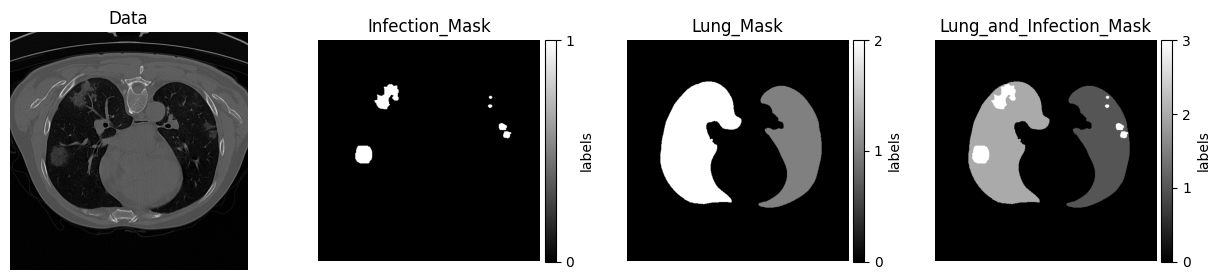

In [3]:
import os
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

DATA_PATH = "/content/drive/MyDrive/few-shot-covid19-seg/data/COVID-19-CT-Seg"
PATIENT_FILE = "coronacases_002.nii.gz"
Z_SLICE = 100

patient_scan = {}
dir_list = ["Data", "Infection_Mask", "Lung_Mask", "Lung_and_Infection_Mask"]

fig, axs = plt.subplots(1, 4, figsize=(15, 9))
fig.subplots_adjust(wspace=0.3)
for i, dir in enumerate(dir_list):
    fpath = os.path.join(DATA_PATH, f"{dir}/{PATIENT_FILE}")
    patient_scan[dir] = sitk.GetArrayFromImage(sitk.ReadImage(fpath))
    if i > 0:
        labels = np.unique(patient_scan[dir])
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        img = axs[i].imshow(patient_scan[dir][Z_SLICE], cmap='gray')
        cbar = fig.colorbar(img, cax=cax, ticks=labels, label='labels')
    else:
        axs[i].imshow(patient_scan[dir][Z_SLICE], cmap='gray')
    axs[i].set_title(dir, fontsize=12)
    axs[i].axis('off')

print(f"The sample scan has shape {patient_scan['Data'].shape}.")
print(f"The images below are from slice number {Z_SLICE}.")
plt.show()

# Data pre-processing

The dataset consists of 10 scans encoded as 16-bit grayscale DICOM files, identified by the prefix "coronacases", and 10 scans encoded as 8-bit grayscale DICOM files, identified by the prefix "radiopaedia". The pixel intensity for the 16-bit images ranges from a minimum of -1023 to a maximum of 9567, while for the 8-bit images the range lies within [0, 255].

The data pre-processing includes the following steps: 

1.   Region of Interest (ROI) cropping;
2.   Resizing;
3.   Windowing (only for 16-bit data);
4.   Normalisation;
5.   Annotation-only slice selection.



## ROI cropping

The crop region is selected on a per-patient basis, by identifying the point in the lungs masks closest to each image boundary (left, right, bottom, top) and choosing the ones with smallest distance across the whole volume. This ensures the lung region always lies within the cropping area.

In [4]:
from typing import Tuple

def crop_roi_per_volume(mask: np.ndarray, eps: int) -> Tuple[int]:
    """
    Finds the optimal 2D ROI cropping area for a CT volume.

    Args:
        mask: Lungs segmentation mask, shape (Nz, Nx, Ny)
        eps: maximum extra crop margin to avoid edge effects
    Returns:
        crop: Tuple of indices for cropping area
    """

    assert (len(mask.shape) == 3) and (eps >= 0)

    Nz, Nx, Ny = mask.shape
    crop = {'t': Nx, 'b': 0, 'l': Ny, 'r': 0}

    for mask_slice in mask:
        # Find mask indices closest to each image boundary
        try:
            lung_idx = np.nonzero(mask_slice > 0)    # 0 = background label
            t, b = np.min(lung_idx[0]), np.max(lung_idx[0])  # x-range
            l, r = np.min(lung_idx[1]), np.max(lung_idx[1])  # y-range
        except ValueError:
            # No lungs in current slice
            continue

        # Select largest cropping area across slices
        crop['t'] = np.min([crop['t'], t])
        crop['b'] = np.max([crop['b'], b])
        crop['l'] = np.min([crop['l'], l])
        crop['r'] = np.max([crop['r'], r])

    crop_width = crop['r'] - crop['l']
    crop_height = crop['b'] - crop['t']
    scale_diff = crop_width - crop_height
    
    # If crop_width != crop_height enforce a square crop within image boundaries
    if scale_diff > 0:

        b_boundary_flag = np.argmin(np.array([scale_diff//2, Nx-crop['b']]))
        t_boundary_flag = np.argmin(np.array([scale_diff-scale_diff//2, crop['t']]))

        if b_boundary_flag:     # Square overshoots bottom edge
            crop['b'] = Nx
            new_height = crop['b'] - crop['t']
            crop['t'] -= crop_width - new_height           
        elif t_boundary_flag:   # Square overshoots top edge
            crop['t'] = 0
            new_height = crop['b'] - crop['t']
            crop['b'] += crop_width - new_height        
        else:
            crop['b'] += scale_diff//2
            crop['t'] -= scale_diff - scale_diff//2

    elif scale_diff < 0:

        r_boundary_flag = np.argmin(np.array([scale_diff//2, Ny-crop['r']]))
        l_boundary_flag = np.argmin(np.array([scale_diff-scale_diff//2, crop['l']]))

        if r_boundary_flag:     # Square overshoots right edge
            crop['r'] = Ny
            new_width = crop['r'] - crop['l']
            crop['l'] -= crop_height - new_width           
        elif t_boundary_flag:   # Square overshoots left edge
            crop['l'] = 0
            new_width = crop['r'] - crop['l']
            crop['r'] += crop_height - new_width     
        else:
            crop['r'] -= scale_diff//2
            crop['l'] += scale_diff - scale_diff//2

    # Add extra margin
    crop['t'] -= eps
    crop['b'] += eps
    crop['l'] -= eps
    crop['r'] += eps

    # Adjust square for overflowing edges
    opposite_edges = {'t':'b', 'b':'t', 'l':'r', 'r':'l'}
    overflow = np.array([crop['t'], Nx-crop['b'], crop['l'], Ny-crop['r']]) # <0 if overflowing

    for i in np.nonzero(overflow < 0)[0]:
        # Clip overflowing edge to image boundary
        over_edge = list(crop)[i]
        b_r = (over_edge=='b' or over_edge=='r')
        t_l = (over_edge=='t' or over_edge=='l')
        crop[over_edge] = Nx*b_r + 0*t_l 

        # Increment/Decrement opposite edge 
        increment = np.min([Nx, crop[opposite_edges[over_edge]] - overflow[i]])
        decrement = np.max([0, crop[opposite_edges[over_edge]] + overflow[i]])
        crop[opposite_edges[over_edge]] =  increment*t_l + decrement*b_r

    return (crop['t'], crop['b'], crop['l'], crop['r'])

---
Let's have a look at the result of ROI cropping on a sample data volume.

Original shape: (200, 512, 512)  -->  Cropped shape: (200, 472, 472)


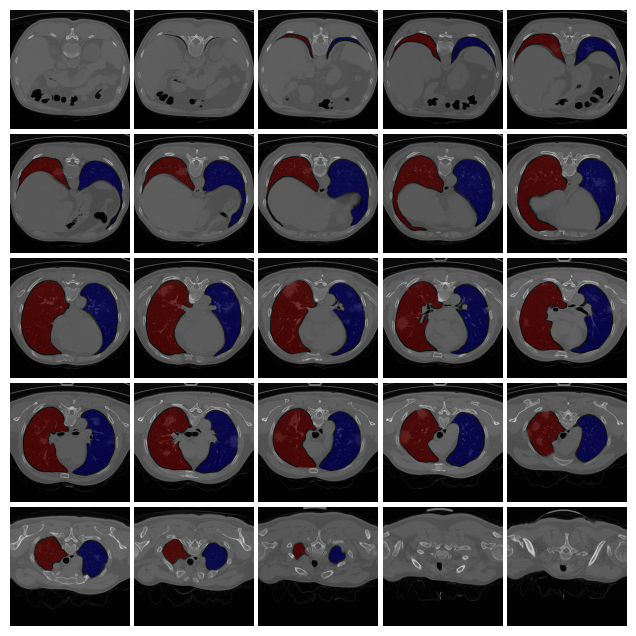

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

sample_data = patient_scan["Data"]
sample_mask = patient_scan["Lung_Mask"]
sample_mask = np.ma.masked_where(sample_mask < 1, sample_mask)  # For visualisation
margin = 25

crop = crop_roi_per_volume(sample_mask, margin)
print(f"Original shape: {sample_mask.shape}  -->  "
      f"Cropped shape: {(sample_mask.shape[0], crop[1]-crop[0], crop[3]-crop[2])}")

n_images = 25
cropped_data = [sample_data[z, crop[0]:crop[1], crop[2]:crop[3]] 
    for z in range(0, sample_data.shape[0], sample_data.shape[0]//n_images)]
cropped_mask = [sample_mask[z, crop[0]:crop[1], crop[2]:crop[3]] 
    for z in range(0, sample_data.shape[0], sample_data.shape[0]//n_images)]

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.05)
for ax, im, mask in zip(grid, cropped_data, cropped_mask):
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap='jet', alpha=0.5)
    ax.axis('off')
plt.show()

## Resizing and windowing

Resizing consists in shrinking the resolution of the image in order to decrease the computational burden of the deep learning model. Here we apply a per-slice resizing with a target resolution of 256$\times$256, using the automatic routine in the OpenCV library.

Windowing is used to increase the contrast across a region of interest, by clipping the pixel intensity of a CT scan according to a window specific to each organ/tissue. A window is defined by the window level $WL$ (its centre) and the window width $WW$. Typical window values for the lungs are $WL=-600$, $WW=1500$ ([reference](https://radiopaedia.org/articles/windowing-ct)). Here we use $WL=-500$, $WW=1500$ for improved contrast.

In [6]:
from typing import Dict
import cv2

def resize_and_window(
    in_data: Dict[str, np.ndarray],
    out_size: Tuple[int],
    window_vals: Tuple[int]=None
) -> Dict[str, np.ndarray]:

    """
    Resize input data to target size and threshold pixel intensity via windowing.
    Resizing is only applied to the second and third dimensions (transversal section)
    of the input arrays.

    Args:
        in_data: Data dictionary containing a CT volume and corresponding masks
        out_size: Target shape of transversal section after resizing
        window_vals: WL and WW values for lungs window 
    Returns:
        out_data: Resized and windowed in_data
    """

    assert len(out_size) == 2
    out_data = {}

    # Resize all slices of data volume and masks
    for key in in_data.keys():
        out_volume = np.zeros((in_data[key].shape[0],) + out_size)
        for i, zslice in enumerate(in_data[key]):
            out_volume[i] = cv2.resize(
                zslice, dsize=out_size, interpolation=cv2.INTER_NEAREST
            )
        out_data[key] = out_volume

    # Threshold data slice intensity
    if window_vals:
        wl, ww = window_vals
        out_data["Data"] = np.clip(out_data["Data"], wl-(ww//2), wl+(ww//2))
            
    return out_data

---
Let's look at the effects of resizing and windowing on a sample data slice.

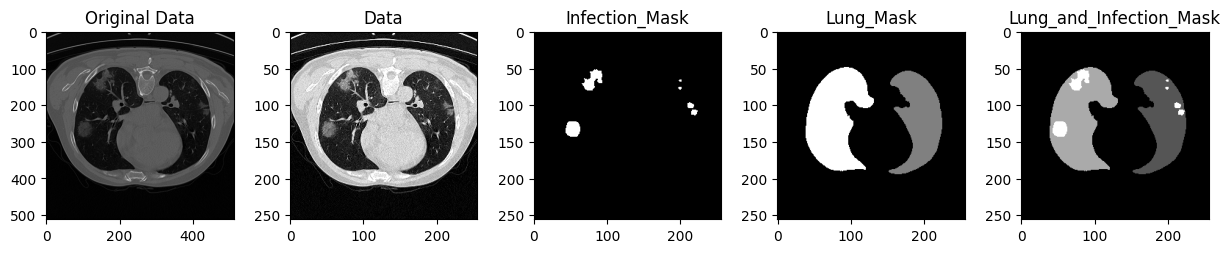

In [7]:
out_size = (256, 256)
window_vals = (-500, 1500)

sample_out_data = resize_and_window(patient_scan, out_size, window_vals)

fig, axs = plt.subplots(1, 5, figsize=(15, 9))
fig.subplots_adjust(wspace=0.3)

for i, key in enumerate(sample_out_data.keys()):
    axs[i+1].imshow(sample_out_data[key][Z_SLICE], cmap='gray')
    axs[i+1].set_title(key, fontsize=12)
axs[0].imshow(patient_scan["Data"][Z_SLICE], cmap='gray')
axs[0].set_title("Original Data", fontsize=12)
plt.show()

## Normalisation

Here normalisation is global, i.e. the normalisation statistics are calculated from the entire dataset and then applied individually to each patient's volume. Notice that the pixel intensity range for the 16-bit scans is different from the 8-bit scans, therefore the population used to calculate the global normalisation statistics is a user choice.

In [8]:
from typing import List
import h5py

def global_normalisation_stats(patient_paths: List[str]) -> Dict[str, float]:
    """
    Calculate global statistics for normalisation from list of patient CT scans.

    Args:
        patient_paths: List of paths to patients CT scans
    Returns:
        Dictionary containing the global statistics for normalisation
    """
    assert len(patient_paths) > 0

    global_stats = {
        'mean': 0.0,
        'stdev': 0.0,
        'min': 32767.0,
        'max': 0.0,
    }
    
    for fpath in patient_paths:
        if fpath.endswith(".nii.gz"):
            patient_data = sitk.GetArrayFromImage(sitk.ReadImage(fpath))
        elif fpath.endswith(".h5"):
            with h5py.File(fpath, "r") as f:
                patient_data = np.array(f["Data"])

        global_stats['mean'] += np.mean(patient_data)
        global_stats['min'] = np.min([global_stats['min'], np.min(patient_data)])
        global_stats['max'] = np.max([global_stats['max'], np.max(patient_data)])

    global_stats['mean'] /= len(patient_paths)

    for fpath in patient_paths:
        if fpath.endswith(".nii.gz"):
            patient_data = sitk.GetArrayFromImage(sitk.ReadImage(fpath))
        elif fpath.endswith(".h5"):
            with h5py.File(fpath, "r") as f:
                patient_data = np.array(f["Data"])

        global_stats['stdev'] += np.sqrt(np.mean((patient_data - global_stats['mean'])**2))

    global_stats['stdev'] /= len(patient_paths)

    return global_stats

---
Let's calculate the global normalisation statistics for the entire dataset, as well as separately for the 16-bit and 8-bit sub-sets.

In [9]:
data_dir_files = os.listdir(os.path.join(DATA_PATH, "Data"))
CT_scans_paths = [os.path.join(DATA_PATH, f"Data/{f}") for f in data_dir_files]
patient_paths_all = [path for path in CT_scans_paths if path.endswith(".nii.gz")]
patient_paths_16bit = [path for path in CT_scans_paths if path.split("/")[-1].startswith("coronacases")]
patient_paths_8bit = [path for path in CT_scans_paths if path.split("/")[-1].startswith("radiopaedia")]

paths = [patient_paths_all, patient_paths_16bit, patient_paths_8bit]
sets = ['entire dataset', '16-bit sub-subset', '8-bit sub-set']

for p, s in zip(paths, sets):
    stats = global_normalisation_stats(p)
    print(
        f"Global stats for {s}:  "
        f"min {stats['min']}, "
        f"max {stats['max']}, "
        f"mean {stats['mean']:.2f}, "
        f"stdev {stats['stdev']:.2f}"
    )

Global stats for entire dataset:  min -1023.0, max 9567.0, mean -219.59, stdev 474.69
Global stats for 16-bit sub-subset:  min -1023.0, max 9567.0, mean -558.36, stdev 494.44
Global stats for 8-bit sub-set:  min 0.0, max 255.0, mean 119.17, stdev 90.20


## Slice selection

It is often the case that in a 3d medical imaging dataset, not all slices contain annotations of a given label (background label won't be considered). In few-shot segmentation training we're only interested in slices containing annotations, therefore for each segmentation label we want to create a function that outputs all the slices containing the corresponding annotation. In addition, the function will remove the first and last few slices that are background only.

In [10]:
def slices_with_annotation(
    data: Dict[str, np.ndarray],
    threshold: List[float],
) -> Tuple[Dict[str, np.ndarray], Dict[str, List[int]]]:
    """
    Selects annotation-only slices for labels "1: left_lung", "2: right_lung",
    "3: infection" given an input segmentation mask volume.

    Args:
        data: Dictionary containing the patient data
        threshold: List of minimum pixel densities for each label
    Returns:
        The patient data with volume trimmed to annotations-only slices and a
        dictionary containing a list of selected slices for each segmentation label
    """
    assert len(data['Data'].shape) == 3

    Nz, Nx, Ny = data['Data'].shape
    slice_area = Nx*Ny

    out_slices = {'left_lung':[], 'right_lung':[], 'infection':[]}

    # Add slice if density of segmentation area is greater than min density
    for i, mask_slice in enumerate(data['Lung_Mask']):
        label, count = np.unique(mask_slice, return_counts=True)
        if len(count)==1: continue     # Only background

        l_lung = count[label==1] if 1 in label else 0  # Pixel count for left lung
        r_lung = count[label==2] if 2 in label else 0  # Pixel count for left lung

        if l_lung/slice_area > threshold[0]:  
            out_slices['left_lung'].append(i)
        if r_lung/slice_area > threshold[1]:
            out_slices['right_lung'].append(i)

    for i, mask_slice in enumerate(data['Infection_Mask']):
        _, count = np.unique(mask_slice, return_counts=True)
        if len(count)==1: continue
        if count[1]/slice_area > threshold[2]: # Pixel density for infection
            out_slices['infection'].append(i)

    # Select volume range containing all annotations
    z_start = min(map(lambda x: x[0], out_slices.values()))  # Smallest first slice
    z_end = max(map(lambda x: x[-1], out_slices.values()))   # Largest last slice

    # Remove background-only slices from data
    out_data = {}
    for key in data.keys():
        out_data[key] = data[key][z_start : z_end+1]

    # Adjust slice index to match output data volume range
    for label in out_slices.keys():
        out_slices[label] = list(map(lambda x: x - z_start, out_slices[label]))

    return out_data, out_slices

# Putting everything together

We are now ready to apply all the pre-processing steps to the dataset and export it into a new folder. Normalisation won't be applied immediately, but information on global statistics and annoteded slices will also be exported, so as to leave the choice of normalisation and slice selection modality as part of the model design.

Also note that Lung_Mask and Infection_Mask share the label value "1", so we will need to re-map them into a non-overlapping set of integers (in this case it's sufficient to change the value of the infection label to "3").

In [11]:
import json

# Set up environment with in/out paths to dataset files
DATA_PATH = "/content/drive/MyDrive/few-shot-covid19-seg/data/COVID-19-CT-Seg"
OUT_PATH = "/content/drive/MyDrive/few-shot-covid19-seg/data/preprocessed_data"
DATA_INFO_PATH = "/content/drive/MyDrive/few-shot-covid19-seg/data/data_info"
DIR_LIST = ["Data", "Infection_Mask", "Lung_Mask", "Lung_and_Infection_Mask"]

data_dir_files = os.listdir(os.path.join(DATA_PATH, "Data"))
patient_files = [f for f in data_dir_files if f.endswith(".nii.gz")]

# Pre-processing settings
EPS = 25
OUT_SIZE = (256, 256)
WINDOW_VALS = (-500, 1500)
THRESHOLD = [0.005, 0.005, 0.0003]

slice_idxs_per_patient = {}

# Data pre-processing
for patient in patient_files:

    # Read patient's CT scan and segmentation masks
    print(f"Reading patient file {patient}")
    data = {}
    for dir in DIR_LIST:
        fpath = os.path.join(DATA_PATH, f"{dir}/{patient}")
        sitk_obj = sitk.ReadImage(fpath)
        data[dir] = sitk.GetArrayFromImage(sitk_obj)
        if dir == "Data":
            bit_type = sitk_obj.GetPixelIDTypeAsString().split('-')[0]

    orig_shape = data["Data"].shape

    # Cropping
    crop = crop_roi_per_volume(data["Lung_Mask"], EPS)
    for dir in DIR_LIST:
        data[dir] = data[dir][:, crop[0]:crop[1], crop[2]:crop[3]]

    # Resizing and windowing
    if bit_type == '16':    # Windowing only on 16-bit data
        data = resize_and_window(data, OUT_SIZE, WINDOW_VALS)
    else:
        data = resize_and_window(data, OUT_SIZE, None)

    # Label remapping (left_lung:1, right_lung:2, infection:3)
    infection_mask = data["Infection_Mask"]
    infection_mask[infection_mask==1] = 3
    data["Infection_Mask"] = infection_mask

    # Slice selection
    data, slice_idxs = slices_with_annotation(data, THRESHOLD)
    patient_id = patient.split('.')[0]
    slice_idxs_per_patient[patient_id] = slice_idxs

    # Scaling to pixel range [0, 255]
    data["Data"] = np.divide(
        (data["Data"] - data["Data"].min()) * 255,
        data["Data"].max() - data["Data"].min()
    )

    final_shape = data["Data"].shape

    # Export preprocessed data
    # We use hdf5 format for faster loading
    with h5py.File(OUT_PATH + f"/{patient_id}.h5", 'w') as f:
        for dir in DIR_LIST:
            out_type = 'float32' if dir=="Data" else 'int8'
            f.create_dataset(f"{dir}", data = data[dir].astype(out_type))   
    print(
        f"File {patient_id}.h5 saved.    Original shape:{orig_shape} "
        f"--> Final shape:{final_shape}"
    )


Reading patient file radiopaedia_14_85914_0.nii.gz
File radiopaedia_14_85914_0.h5 saved.    Original shape:(110, 401, 630) --> Final shape:(108, 256, 256)
Reading patient file coronacases_005.nii.gz
File coronacases_005.h5 saved.    Original shape:(290, 512, 512) --> Final shape:(259, 256, 256)
Reading patient file radiopaedia_36_86526_0.nii.gz
File radiopaedia_36_86526_0.h5 saved.    Original shape:(45, 630, 630) --> Final shape:(45, 256, 256)
Reading patient file radiopaedia_10_85902_1.nii.gz
File radiopaedia_10_85902_1.h5 saved.    Original shape:(39, 630, 630) --> Final shape:(31, 256, 256)
Reading patient file coronacases_006.nii.gz
File coronacases_006.h5 saved.    Original shape:(213, 512, 512) --> Final shape:(173, 256, 256)
Reading patient file coronacases_004.nii.gz
File coronacases_004.h5 saved.    Original shape:(270, 512, 512) --> Final shape:(248, 256, 256)
Reading patient file coronacases_007.nii.gz
File coronacases_007.h5 saved.    Original shape:(249, 512, 512) --> Fin

In [12]:
# Compute global statistics for normalisation of pre-processed data
preprocessed_patient_files = os.listdir(OUT_PATH)
preprocessed_patient_paths = [os.path.join(OUT_PATH, f) for f in preprocessed_patient_files]

global_stats = global_normalisation_stats(preprocessed_patient_paths)

# Compile json for pre-processed data
for patient in preprocessed_patient_files:

    with h5py.File(os.path.join(OUT_PATH, patient), "r") as f:
        img = np.array(f["Data"])

    # Export patient info to json (global statistics + annotated slices)
    patient_id = patient.split('.')[0]
    patient_info = {
        "patient_id": patient_id,
        "img_shape": img.shape,
        "patient_min_max": (np.min(img).astype('float64'), np.max(img).astype('float64')),
        "patient_mean_std": (np.mean(img).astype('float64'), np.std(img).astype('float64')),
        "global_min_max": (global_stats["min"].astype('float64'), global_stats["max"].astype('float64')),
        "global_mean_std": (global_stats["mean"].astype('float64'), global_stats["stdev"].astype('float64')),
        "annotated_slices": slice_idxs_per_patient[patient_id], 
    }
    with open(DATA_INFO_PATH + f"/{patient_id}.json", 'w') as f:
        json.dump(patient_info, f, indent=4)
